In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from src.catalogs import (
    JapanSlowSlipCatalog,
    RoussetSlowSlipCatalog, 
    XieSlowSlipCatalog,
    WilliamsSlowSlipCatalog,
    MichelSlowSlipCatalog,   # too few earthquakes to estaplish rate changes 
)

from src.data import (
    AllSlabs, 
    EarthquakeCatalog,
    SlowSlipCatalog,
    Scaling
)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde
from tqdm import tqdm

import warnings

import src
from pathlib import Path
base_dir = Path(src.__file__).parents[1]

mpl.rc('figure',dpi=300)
mpl.rc('font',size=8)

# Global analysis of slow slip

## Datasets

`AllSlabs` loads in all the slab geometries from Slab2.0

In [44]:
all_slabs = AllSlabs()

We now load in all the slow slip datasets. Please refer to `Datasets/Slow_slip_datasets` for detailed metadata for each datasets.

In [45]:

slowslip = [
    JapanSlowSlipCatalog().get_nankai_trough(),
    JapanSlowSlipCatalog().get_ryukyu_trench(),
    JapanSlowSlipCatalog().get_japan_trench(),
    RoussetSlowSlipCatalog(), 
    XieSlowSlipCatalog(),
    WilliamsSlowSlipCatalog(),
]

all_slowslip = sum(slowslip[1:], slowslip[0])

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/catalog.py:70: UserWarning: Catalog does not have depth column, this may cause errors.
  warnings.warn(


In [53]:
print(slowslip[2].catalog.lat.mean())
print(slowslip[1].catalog.lat.mean())


35.81695394736842
26.55685625


We now load earthquakes (the first time this is run, it will take a while to download the data).

In [46]:
minimum_magnitude = 4
earthquakes = EarthquakeCatalog(
    filename=base_dir / "Datasets" / "Seismicity_datasets" / "global_earthquakes.csv",
    use_other_catalog=True,
    other_catalog=all_slowslip,
    other_catalog_buffer=5, # buffer in degrees
    kwargs={"minimum_magnitude":minimum_magnitude},
)

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:87: UserWarning: Longitude range exceeds 180 degrees. Setting to 180.
  warnings.warn("Longitude range exceeds 180 degrees. Setting to 180.")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:179: UserWarning: Using existing /Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/Datasets/Seismicity_datasets/global_earthquakes.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:185: UserWarning: 260 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


In [47]:
local_earthquakes = earthquakes.intersection(all_slowslip,buffer_radius_km=500.0)
distance_to_slab = all_slabs.distance(
    local_earthquakes.catalog[["lat","lon","depth"]].values,
    depth_unit="km",
    distance_unit="km",
)
local_earthquakes = EarthquakeCatalog(local_earthquakes.catalog.loc[distance_to_slab < 20])

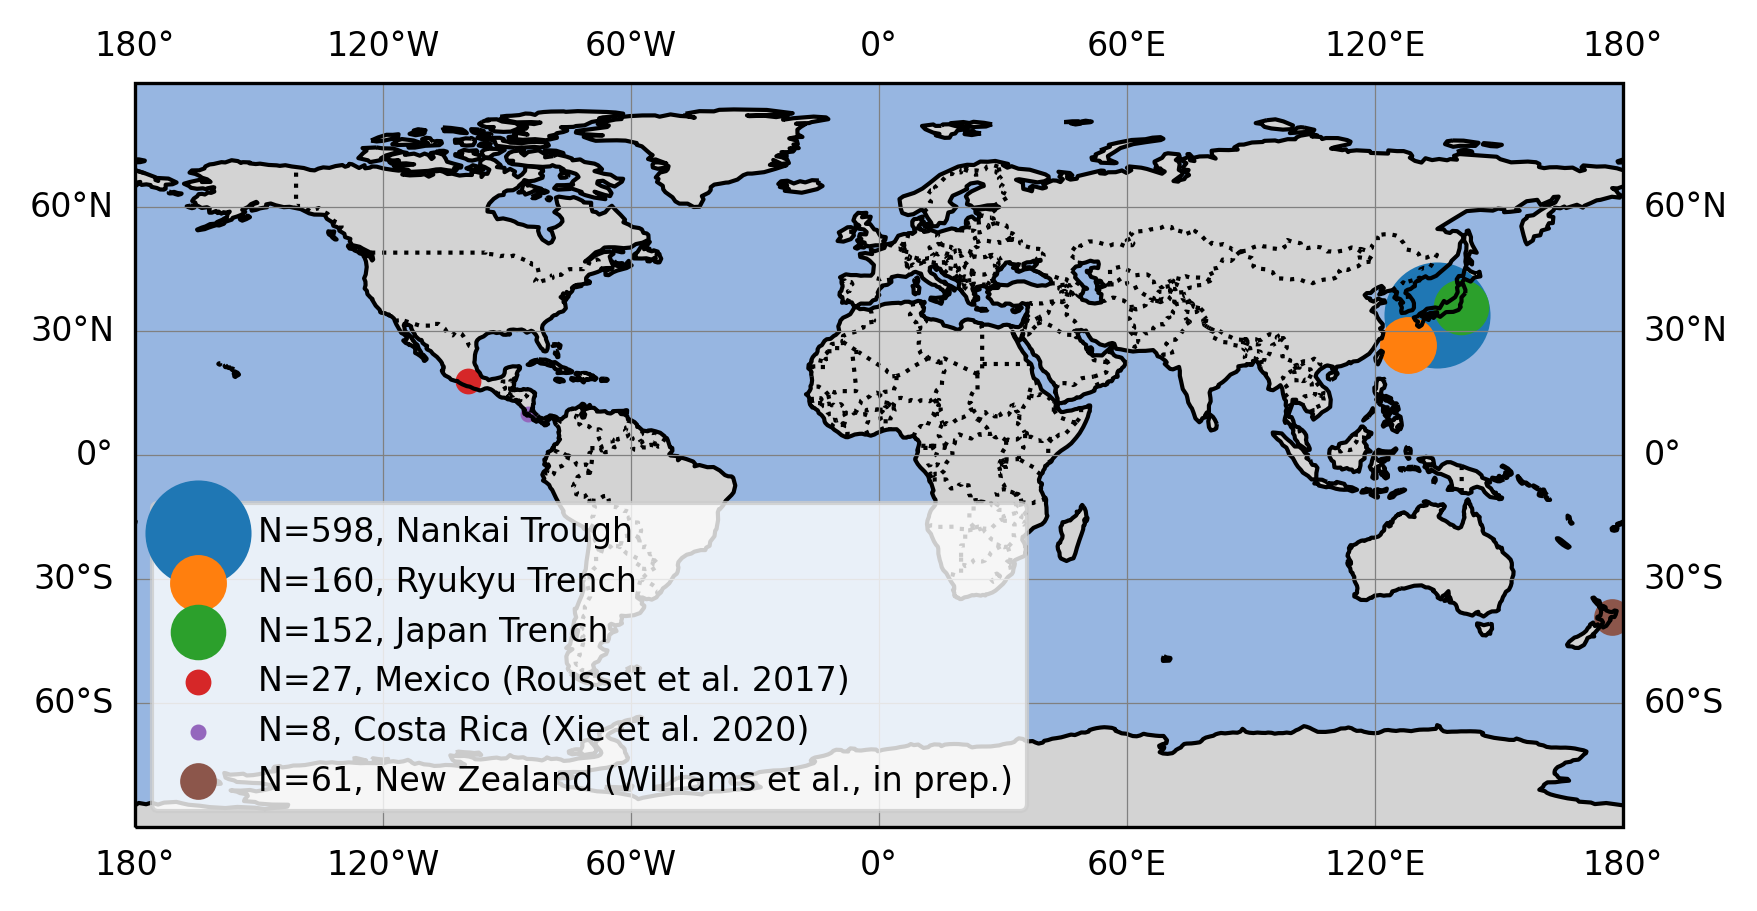

In [54]:
_, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
usemap_proj = ccrs.PlateCarree()
# set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
extent = [-180,180,-90,90]

ax.set_extent(
    extent,
    crs=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# plot grid lines
ax.gridlines(draw_labels=True, crs=usemap_proj, color="gray", linewidth=0.3)

for i_slowslip in slowslip:
    ax.scatter(
        np.mean(i_slowslip.catalog.lon),
        np.mean(i_slowslip.catalog.lat),
        s=len(i_slowslip),
        label=f"N={len(i_slowslip)}, {i_slowslip.name}",
    )

ax.legend(loc='lower left')

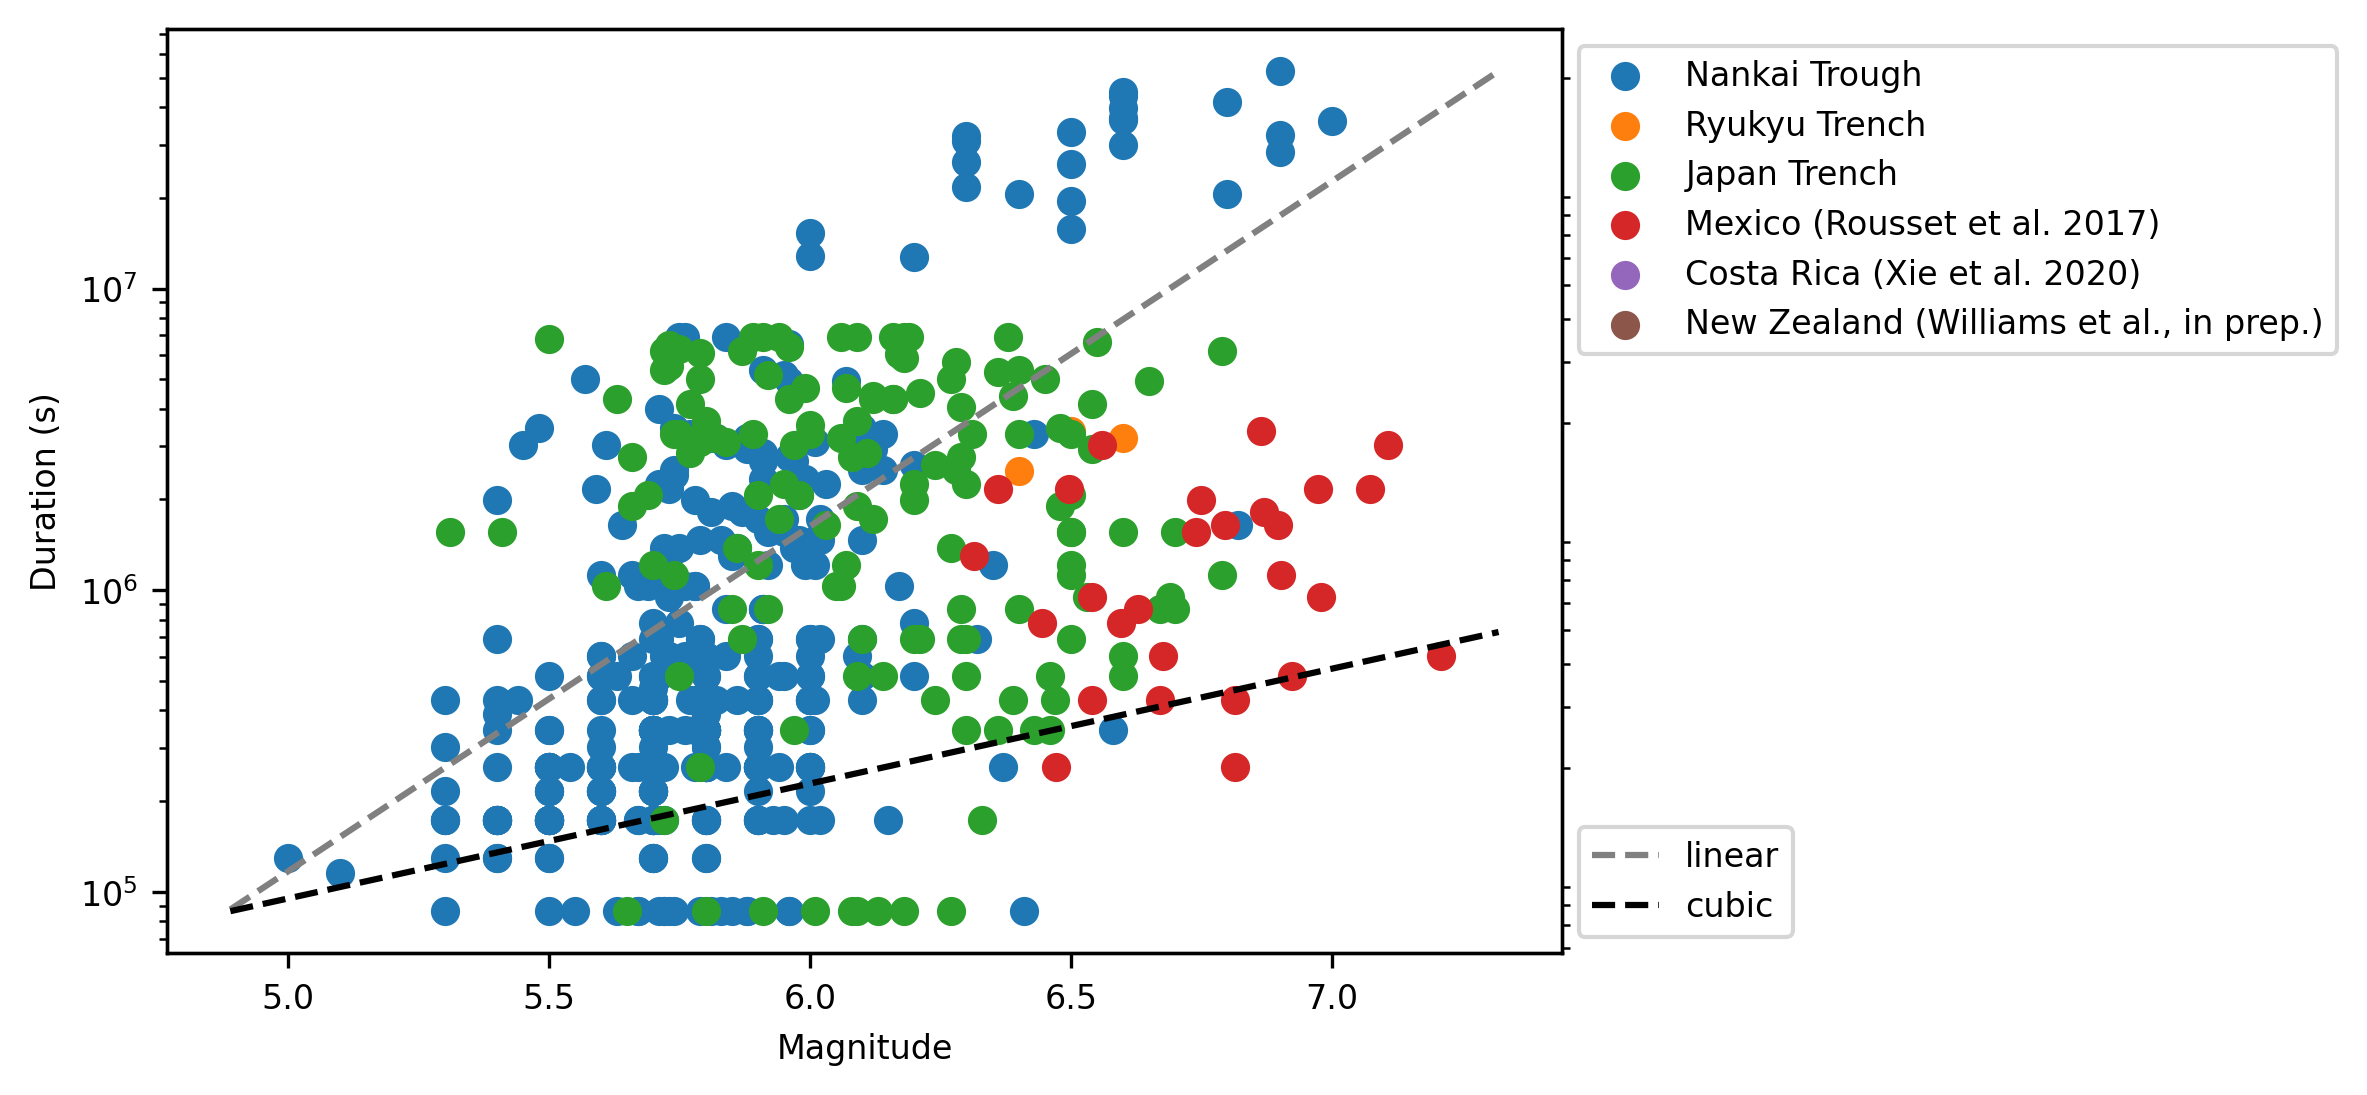

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i_slowslip in slowslip:
    ax.scatter(
        i_slowslip.catalog['mag'],
        i_slowslip.catalog['duration'],
        label=i_slowslip.name,
    )
ax.set(
    xlabel='Magnitude',
    ylabel='Duration (s)',
    yscale='log',
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
xlim = np.array(ax.get_xlim())
axb = ax.twinx()
axb.plot(xlim, 10**xlim, '--', c='grey', label='linear')
axb.plot(xlim, 10**(0.666*xlim[0])*10**(0.333*xlim), '--', c='k', label='cubic')
axb.set(
    yscale='log',
    yticks=[],
)
axb.legend(loc='lower left', bbox_to_anchor=(1,0))


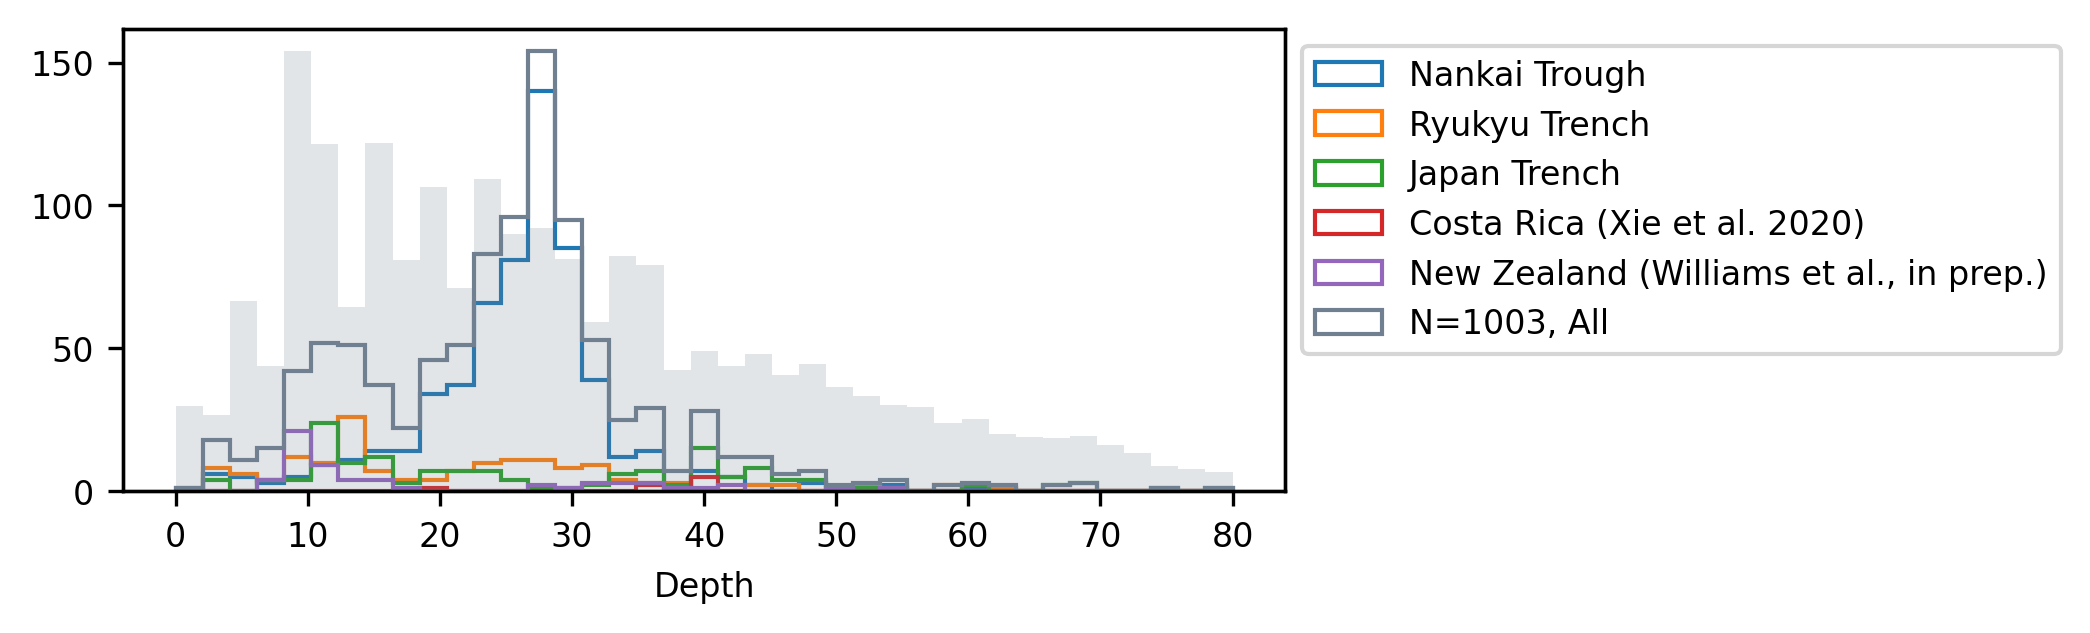

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5,2))
bins = np.linspace(0, 80, 40)
axb = ax.twinx()
axb.hist(
    local_earthquakes.catalog.depth, 
    bins=bins, 
    label=f'N={len(local_earthquakes.slice_by("depth",0,80))}, M{minimum_magnitude}+ Earthquakes', color='slategray', alpha=0.2
)
axb.set(yticklabels=[],yticks=[])
all_depths = []
for i_slowslip in slowslip:
    if 'depth' in i_slowslip.catalog.columns:
        ax.hist(
            i_slowslip.catalog['depth'],
            bins = bins,
            label=i_slowslip.name,
            histtype='step',
        )
        all_depths.append(i_slowslip.catalog['depth'])
ax.hist(
    np.concatenate(all_depths),
    bins = bins,
    label=f'N={len(all_slowslip)}, All',
    histtype='step',
    color='slategray',
)
ax.set(
    xlabel='Depth',
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

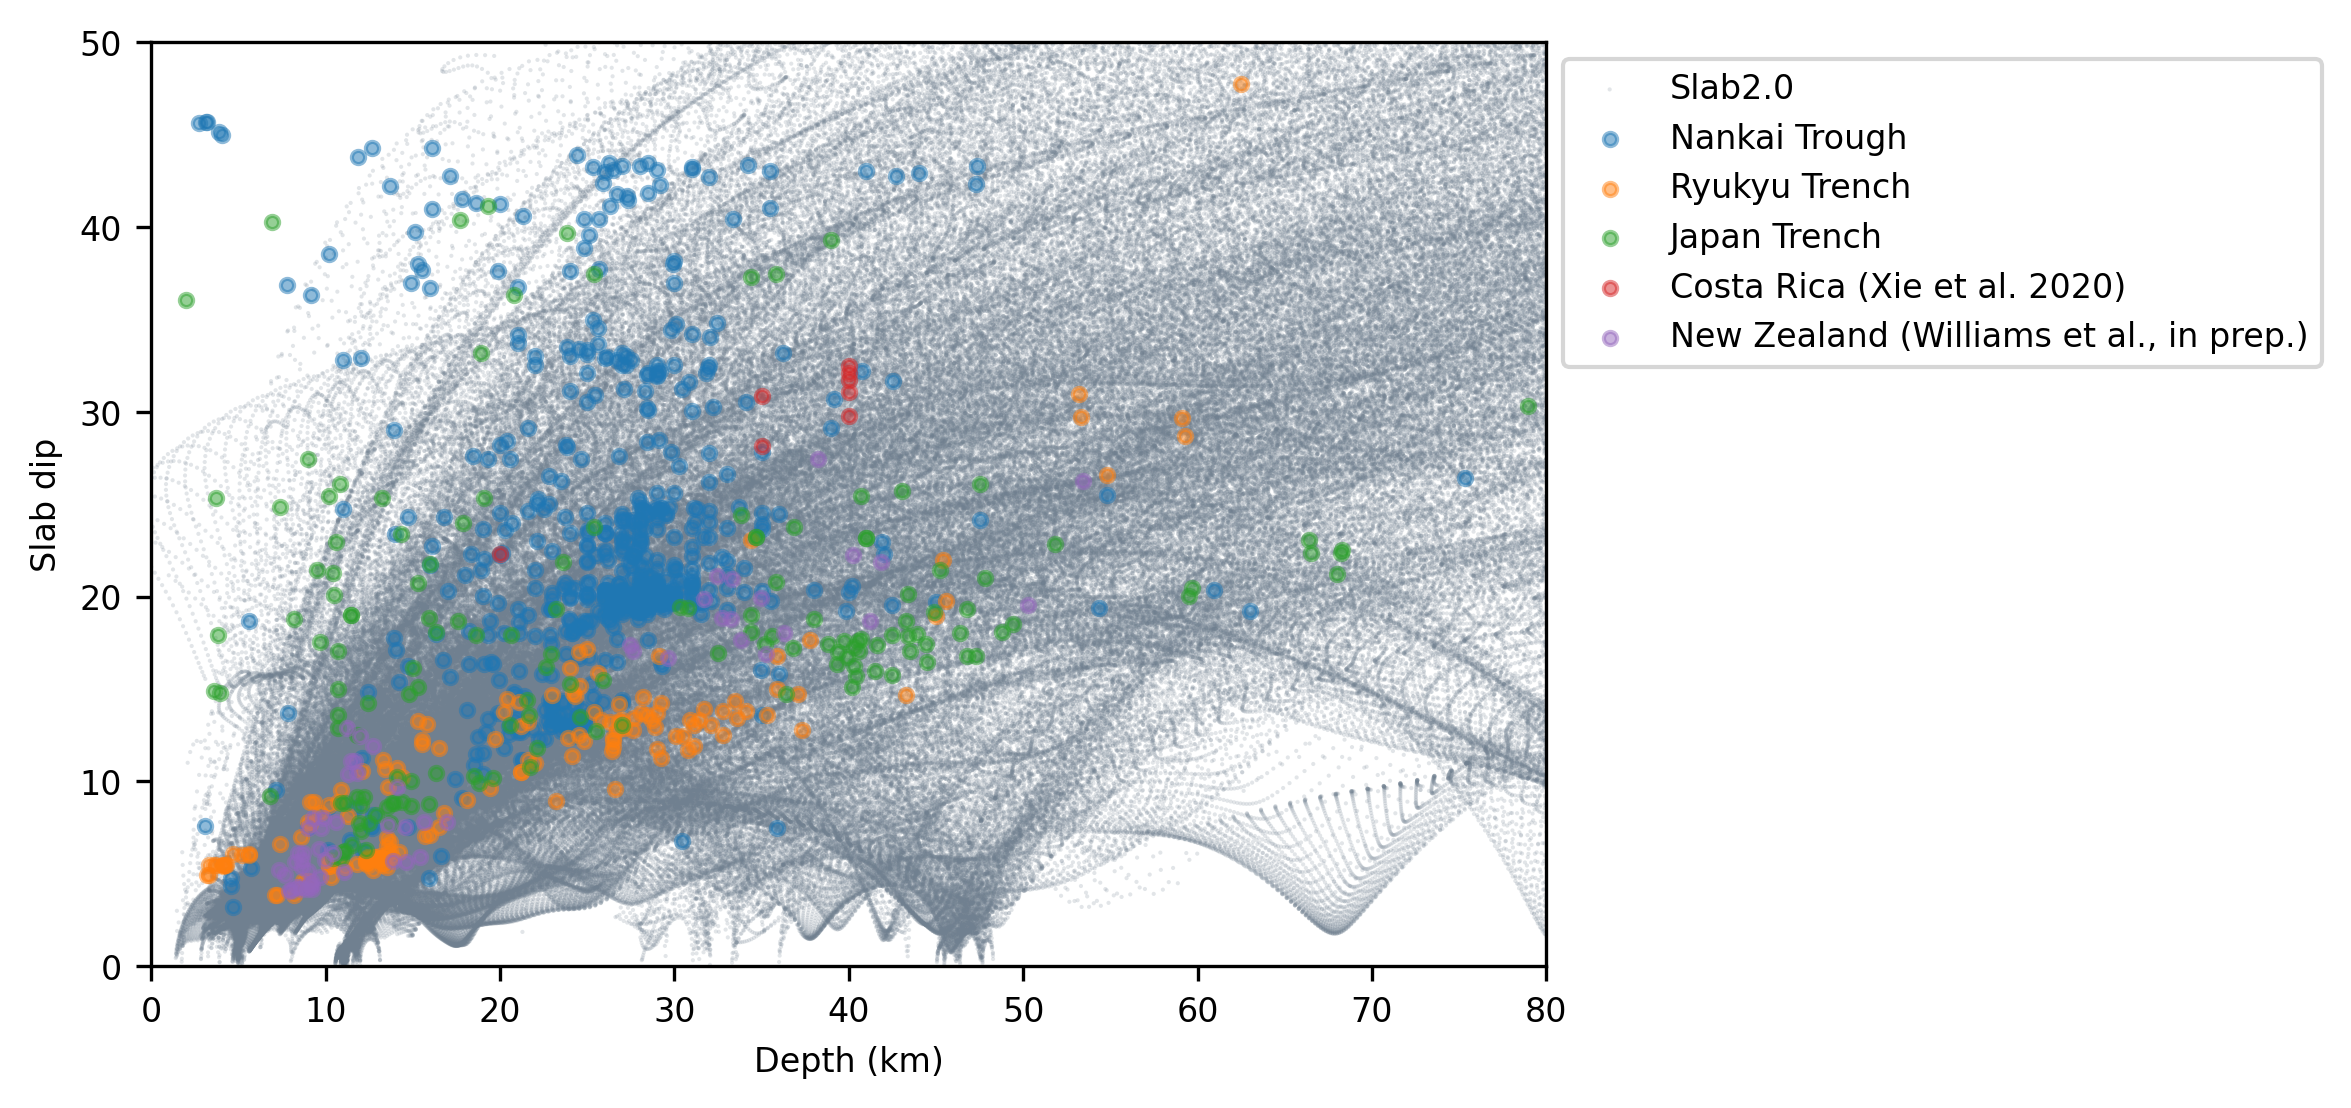

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(all_slabs.depth/1000, all_slabs.dip,s=1,edgecolors=[],alpha=0.2,c='slategrey', label='Slab2.0')
for i_slowslip in slowslip:
    if 'depth' in i_slowslip.catalog.columns:
        ax.scatter(
            i_slowslip.catalog['depth'],
            all_slabs.interpolate('dip', lon=i_slowslip.catalog['lon'], lat=i_slowslip.catalog['lat']),
            alpha=0.5,
            s = 10,
            label=i_slowslip.name,
        )
ax.set(
    ylabel='Slab dip',
    xlabel='Depth (km)',
    ylim=[0,50],
    xlim=[0,80],
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

In [89]:
catalog1 = all_slowslip
catalog2 = local_earthquakes
R = 100
neighboring_indices = catalog1.get_neighboring_indices(catalog2, R)
len(neighboring_indices)

1006

## Global stacking

### Time stacks

In [ ]:
def center_sequences_on(
    catalog1: pd.DataFrame,
    catalog2: pd.DataFrame,
    T=10,
    R=100,
    rotate_to_slab=False,
    slab_model=all_slabs,
):
    """
    Center events within T seconds and R km of each other
    """
    
    # time window
    is_in_time_window = np.abs(catalog1.time.values.reshape(-1,1) - catalog2.time.values.reshape(1,-1)) < T # dimensions: (len(catalog1), len(catalog2))
    
    # space window
    is_in_space_window = np.zeros_like(is_in_time_window)
    neighboring_indices = catalog1.intersection(catalog2, R)
    for i in range(len(catalog1)):
        is_in_space_window[i, neighboring_indices] = True

    # combine time and space windows
    is_in_window = is_in_time_window & is_in_space_window
    
    # for each event in catalog1, get the events in the window and center them
    sequences = []
    for i in range(len(catalog1)):
        if np.any(is_in_window[i]):
            if rotate_to_slab:
                catalog1.loc[i, ['lon', 'lat']] = slab_model.interpolate(
                    ['lon', 'lat'],
                    lon=catalog1.catalog.loc[i, 'lon'],
                    lat=catalog1.catalog.loc[i, 'lat'],
                )
        
        t = catalog2.catalog.time.values[is_in_window[i]] - catalog1.catalog.time.values[i]
        dx,dy = (
            catalog2.catalog.lon.values[is_in_window[i]] - catalog1.catalog.lon.values[i],
            catalog2.catalog.lat.values[is_in_window[i]] - catalog1.catalog.lat.values[i],
        )

        sequences.append(
            pd.DataFrame({
                'time':t,
                'dx':dx,
                'dy':dy,
            })
        )
    
    
        
        
        
    
    
        

In [82]:
# for every slow slip event in the global compilation (all_slowslip) take a histogram of the earthquakes during the time window +/- T before the slow slip event and within W km from the SSE centroid
time_window = 360 # days

def get_earthquake_relative_times(
    catalog = all_slowslip,
    time_window = time_window, # days
    space_window = 100, # km 
    return_weights = True,
):

    relative_times = []
    weights = []

    for i,t in enumerate(catalog.catalog.time.values): 
        time_range = [
            t-np.timedelta64(time_window,'D')/2, 
            t+np.timedelta64(time_window,'D')/2
        ]
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            event_times = local_earthquakes.intersection(
                SlowSlipCatalog(catalog[[i]]),space_window # ...the spatial intersection of the slow slip event and the local earthquakes 
            ).get_time_slice(*time_range).catalog.time.values # ...within the time window
            
        if len(event_times) == 0:
            continue
        
        relative_times.append(event_times-t) 
        weights.append(1/len(event_times)*np.ones(len(event_times)))
        
    relative_times = np.concatenate(relative_times)
    weights = np.concatenate(weights)
    
    I = np.argsort(relative_times)
    relative_times = relative_times[I]/np.timedelta64(1,'D')
    weights = weights[I]
    
    if return_weights:
        return relative_times, weights
    else:
        return relative_times

relative_times, weights = get_earthquake_relative_times()

regional_relative_times = []
regionalized_weights = []

for region in slowslip:
    i_relative_times, i_weights = get_earthquake_relative_times(catalog = region)
    i_weights = i_weights/len(i_relative_times)
    regional_relative_times.append(i_relative_times)
    regionalized_weights.append(i_weights)

regional_relative_times = np.concatenate(regional_relative_times)
regionalized_weights = np.concatenate(regionalized_weights)

Text(0, 0.5, 'Earthquakes')

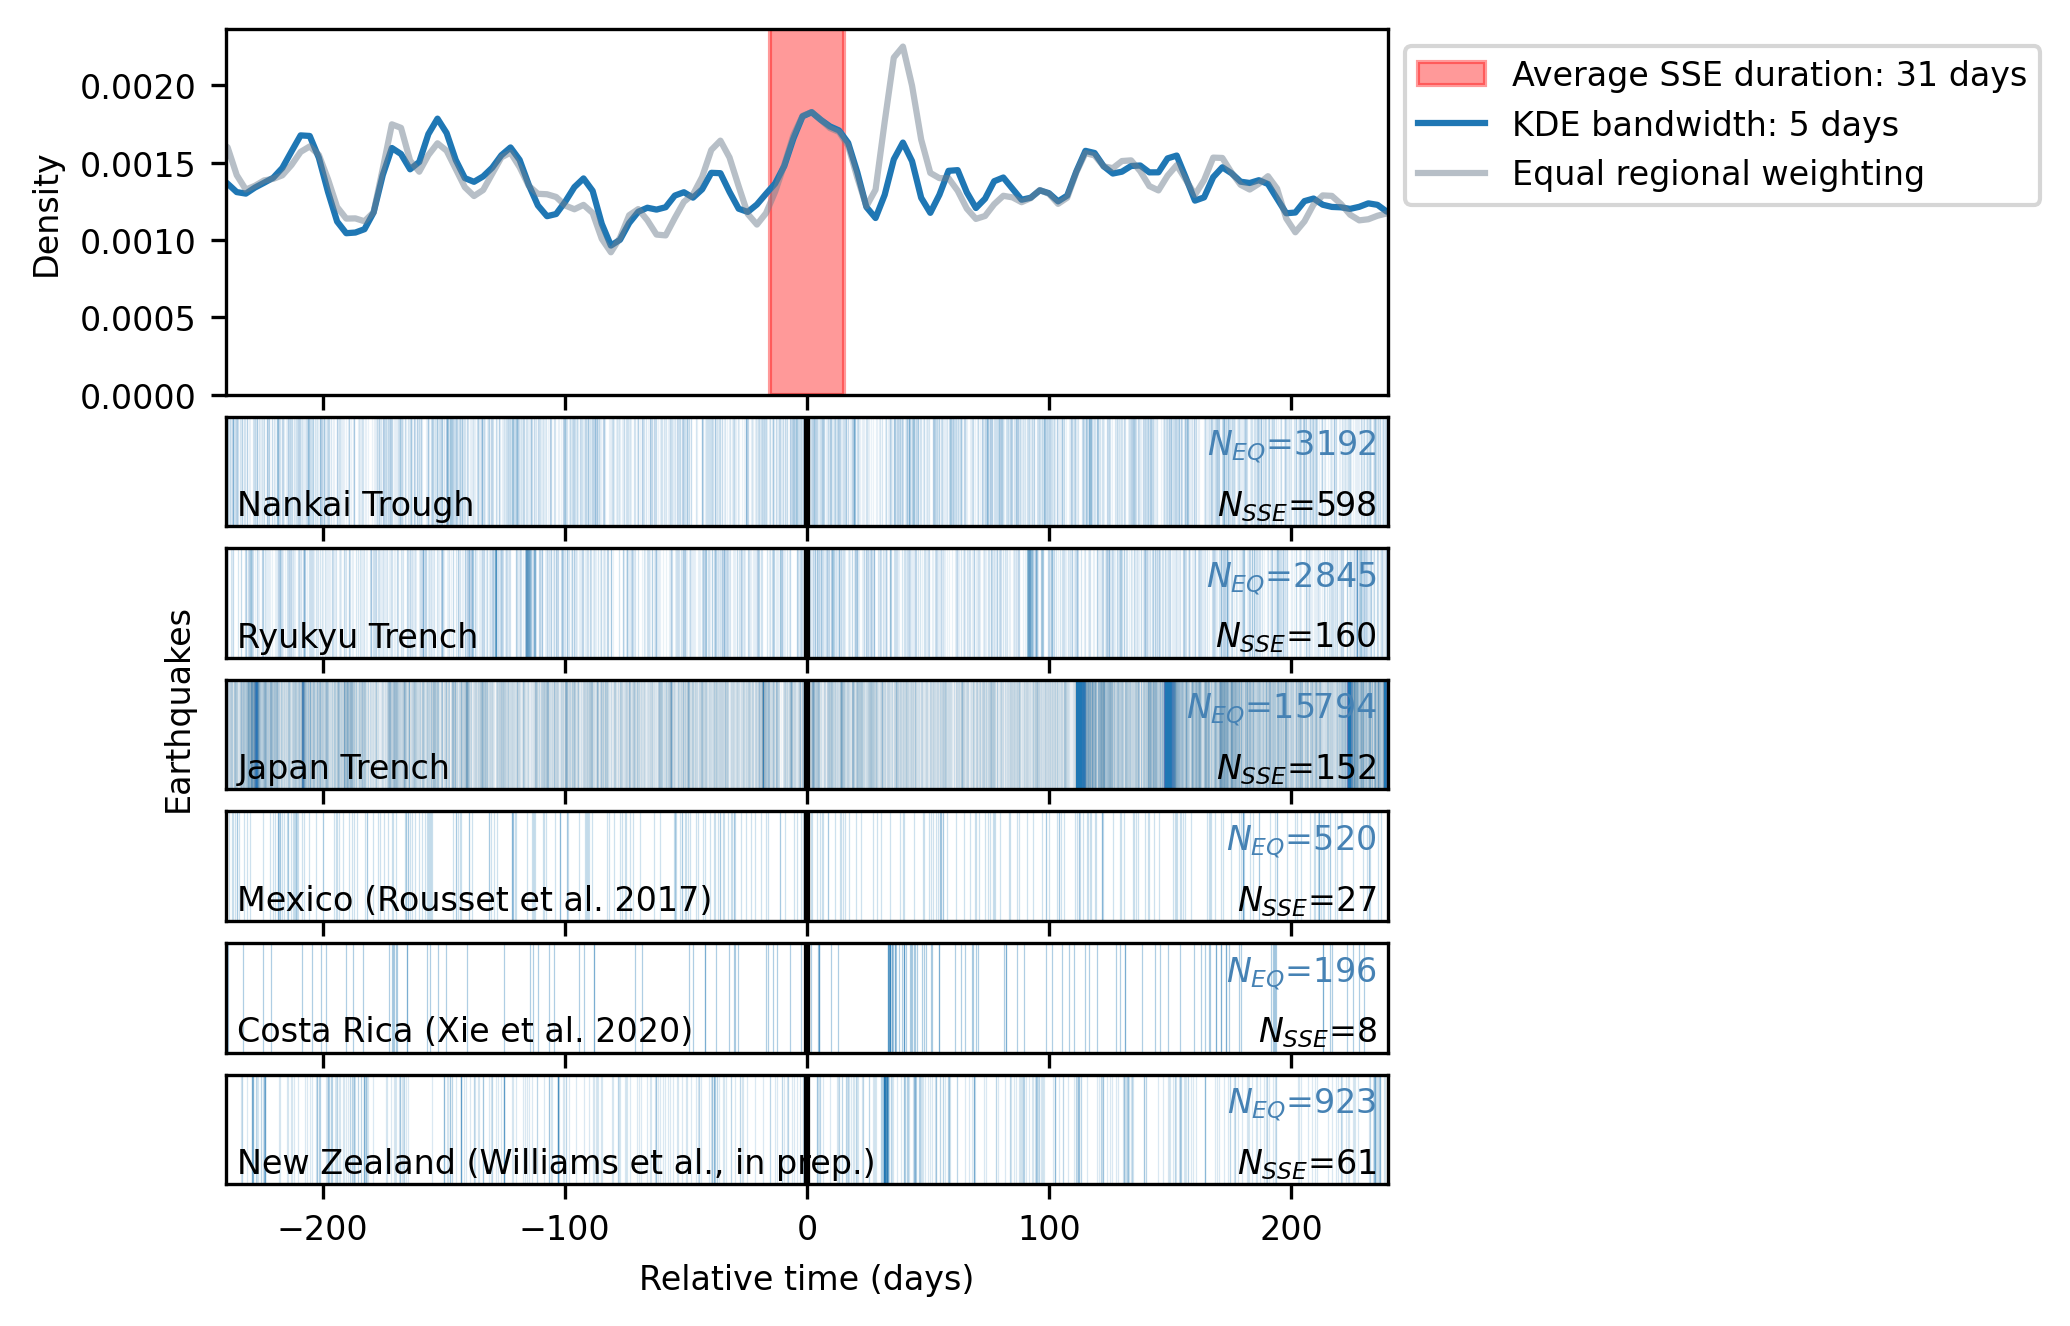

In [84]:
fig, AX = plt.subplots(len(slowslip)+1, 1, figsize=(5,5), sharex=True, gridspec_kw=dict(hspace=0.15, height_ratios=[1]+len(slowslip)*[0.3]))
data_std = np.std(relative_times)
smoothing_bandwidth = 5
bw = smoothing_bandwidth/data_std

average_duration = all_slowslip.catalog['duration'].mean()/60/60/24 
AX[0].axvspan(-average_duration/2, average_duration/2, color='red', alpha=0.4, label=f'Average SSE duration: {average_duration:.0f} days')
sns.kdeplot(
    x=relative_times,
    label=f"KDE bandwidth: {smoothing_bandwidth} days", 
    ax=AX[0],
    **dict(bw_method=bw, weights=weights)
)
sns.kdeplot(
    x=regional_relative_times,
    ax=AX[0], 
    color='slategray',
    label="Equal regional weighting",
    alpha=0.5, 
    **dict(bw_method=bw, weights=regionalized_weights),
)
AX[0].legend(loc='upper left', bbox_to_anchor=(1,1))

# ax.set_yticklabels(ax.get_yticks()*len(relative_times))

for region, iax in zip(slowslip, AX[1:]):
    times = get_earthquake_relative_times(region)[0]
    sns.rugplot(times, ax=iax, label=f'{region.name}', height=1, lw=0.3, alpha=5/np.sqrt(len(times))) 
    iax.set(
        yticks=[],
    )
    iax.text(0.01,0.1,region.name,transform=iax.transAxes)
    iax.text(0.99,0.1,"$N_{SSE}$" + f"={len(region)}",transform=iax.transAxes, ha='right')
    iax.text(0.99,0.9,"$N_{EQ}$" + f"={len(times)}",transform=iax.transAxes, ha='right', va='top', color='steelblue')
    iax.axvline(0, color='k')


AX[-1].set(
    xlabel='Relative time (days)',
    xlim=[-time_window/3,time_window/3],
)

AX[2].set_ylabel('Earthquakes', ha='right')

### Spatial stacks

In [85]:
from joblib import Parallel, delayed

all_slowslip.catalog["strike"] = all_slabs.interpolate(
    'strike', 
    lon=all_slowslip.catalog['lon'].to_numpy(), 
    lat=all_slowslip.catalog['lat'].to_numpy(),
)
all_slowslip.catalog["_stress_drop"] = all_slowslip._stress_drop

def get_single_event_sequence(
    slow_slip_event, 
    time_window, 
    space_window, 
    earthquakes: EarthquakeCatalog = local_earthquakes,
    time_shift=0,
):
    t = slow_slip_event.time
    time_range = [
        t - time_window * np.timedelta64(1,'D')/2 + time_shift * np.timedelta64(1,'D'), 
        t + time_window * np.timedelta64(1,'D')/2 + time_shift * np.timedelta64(1,'D'),
    ]
            
    events = earthquakes.intersection(
        SlowSlipCatalog(pd.DataFrame([slow_slip_event])),space_window # ...the spatial intersection of the slow slip event and the local earthquakes
    ).get_time_slice(*time_range) # ...within the time window
            
            
    if len(events) > 1: # 1 because density calculation goes a bit haywire when there is only 1 event
        
        # get SSE centroid and dimensions, and strike/dip direction from slab
        centroid = slow_slip_event[['lat','lon']].to_numpy()
        strike = slow_slip_event.strike
        sse_east, sse_north, _, _ = all_slabs.force_ll2utm(centroid[0],centroid[1])
        sse_dimension = Scaling.magnitude_to_size(slow_slip_event.mag, slow_slip_event._stress_drop, "m")
        
        east, north, _, _ = all_slabs.force_ll2utm(
            events.catalog['lat'].values, events.catalog['lon'].values
        )
        
        # center and rotate earthquake east and north to strike direction
        xy = np.column_stack((east,north))
        xy = xy - np.array([sse_east, sse_north])
        xy = xy/sse_dimension
        
        R = np.array([
            [np.cos(strike*np.pi/180), -np.sin(strike*np.pi/180)],
            [np.sin(strike*np.pi/180), np.cos(strike*np.pi/180)],
        ])
        xy_rotated = (R @ xy.T).T
        
        return xy_rotated

def spatial_stack(
    slowslip_events: SlowSlipCatalog = all_slowslip, 
    time_window = 30, 
    space_window = 500,
    earthquakes: EarthquakeCatalog = local_earthquakes,
    time_shift = 0,
):
    # Runs get_single_event_sequence for each event in the slowslip catalog in parallel using joblib
    event_stack = Parallel(n_jobs=-1, timeout=999)(
        delayed(get_single_event_sequence)(
            event[1],
            time_window,
            space_window,
            earthquakes,
            time_shift,
        ) for event in slowslip_events
    )
    
    event_stack = [i for i in event_stack if i is not None]
    
    return event_stack
    
T_event = 30 # days
W = 500 # km
print("Processing co-event stack...")
%prun co_event_stack = spatial_stack(all_slowslip, T_event, W, time_shift=0)

T_pre = 360
buffer = 30
print("Processing pre-event stack...")
%prun pre_event_stack = spatial_stack(all_slowslip, T_pre,W, time_shift= (-T_pre/2 - T_event/2 - buffer))

Processing co-event stack...


249315.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249315.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249315.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249315.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249315.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249315.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249315.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249315.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249316.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249316.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/Users/kdascher/miniforge3/env

 Processing pre-event stack...


249405.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249407.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249408.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249411.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249412.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249416.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249417.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249417.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249419.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249420.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249421.04s - pydevd: Sending m

         21538 function calls (21445 primitive calls) in 88.698 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      412   88.557    0.215   88.557    0.215 {method 'acquire' of '_thread.lock' objects}
        1    0.104    0.104    0.104    0.104 {built-in method time.sleep}
        1    0.009    0.009   88.581   88.581 parallel.py:960(retrieve)
     1006    0.005    0.000   88.570    0.088 _base.py:430(result)
        1    0.003    0.003   88.698   88.698 <string>:1(<module>)
      176    0.003    0.000   88.561    0.503 threading.py:288(wait)
     1026    0.002    0.000    0.002    0.000 {method '__enter__' of '_thread.RLock' objects}
     1089    0.001    0.000    0.003    0.000 threading.py:264(__enter__)
     1006    0.001    0.000   88.571    0.088 _parallel_backends.py:562(wrap_future_result)
     1006    0.001    0.000    0.001    0.000 {method 'extend' of 'list' objects}
     1089    0.001    0.000    0.001    0.

249493.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249494.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
249496.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/torchETAS/

[Text(0.5, 0, 'Along-dip (SSE dimensions)')]

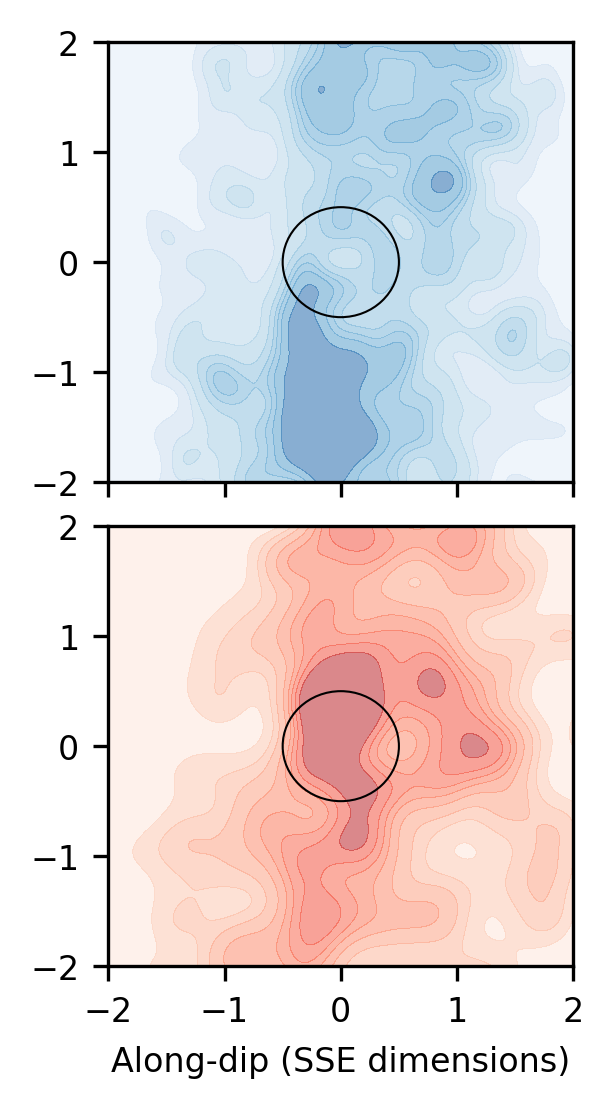

In [81]:
pre_event_stack_combined = np.concatenate(pre_event_stack)
co_event_stack_combined = np.concatenate(co_event_stack)

pre_weights = []
for seq in pre_event_stack:
    pre_weights.append(np.ones(len(seq))/len(seq))
pre_weights = np.concatenate(pre_weights)

co_weights = []
for seq in co_event_stack:
    co_weights.append(np.ones(len(seq))/len(seq))
co_weights = np.concatenate(co_weights)

# drop nan values in both stacks and corresponding weights
pre_weights = pre_weights[~np.isnan(pre_event_stack_combined).any(axis=1)]
co_weights = co_weights[~np.isnan(co_event_stack_combined).any(axis=1)]
pre_event_stack_combined = pre_event_stack_combined[~np.isnan(pre_event_stack_combined).any(axis=1)]
co_event_stack_combined = co_event_stack_combined[~np.isnan(co_event_stack_combined).any(axis=1)]


fig, ax = plt.subplots(2,1,figsize=(2,4), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.1))
shared_kws = dict(
    shade=True,
    shade_lowest=False,
    alpha=0.5,
    clip=[-2,2],
    bw_adjust=0.15,
    levels=np.linspace(0,1,10),
)

sns.kdeplot(pre_event_stack_combined[:,0], pre_event_stack_combined[:,1], cmap='Blues', label='Pre-event', ax=ax[0], **shared_kws, weights=pre_weights)
sns.kdeplot(co_event_stack_combined[:,0], co_event_stack_combined[:,1], cmap='Reds', label='During slow slip', ax=ax[1], **shared_kws, weights=co_weights)  

for iax in ax:
    # plot a circle to show the SSE dimensions
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))

ax[1].set(
    xlabel='Along-dip (SSE dimensions)',
)
    

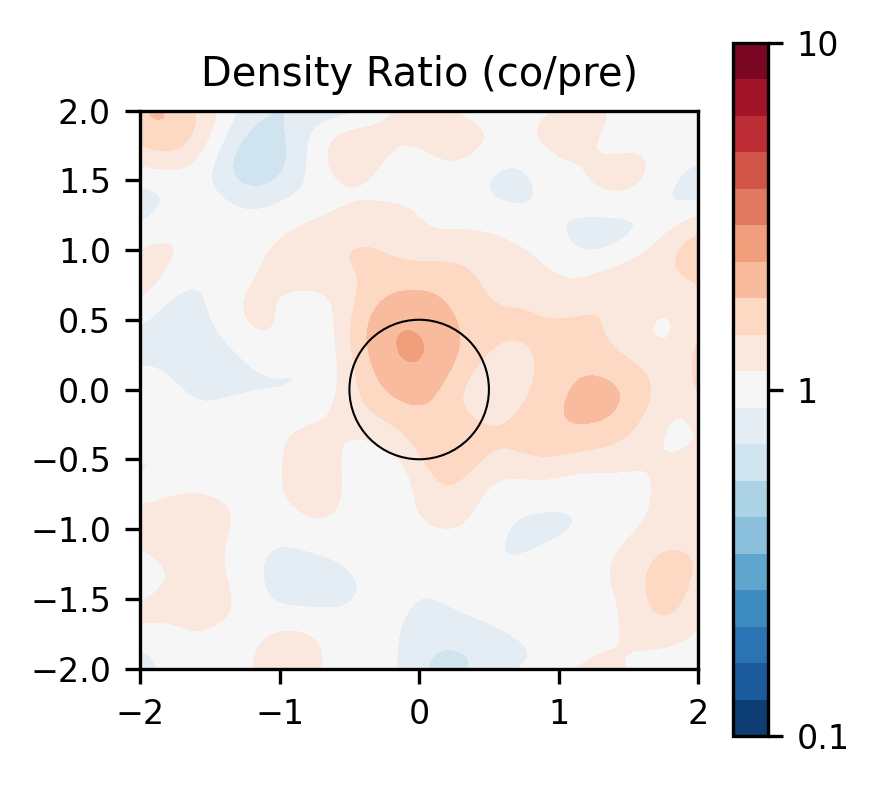

In [78]:


# Define the bandwidth for smoothing
smoothing_bandwidth = 0.04

# Create the kernel density estimators
dens_pre = gaussian_kde(pre_event_stack_combined.T, bw_method=smoothing_bandwidth, weights=pre_weights)
dens_co = gaussian_kde(co_event_stack_combined.T, bw_method=smoothing_bandwidth, weights=co_weights)

# Define the range and grid
number_of_source_dimensions = 2
xmin, xmax = -number_of_source_dimensions, number_of_source_dimensions
ymin, ymax = -number_of_source_dimensions, number_of_source_dimensions
grid_size = 100

# Create a grid of points
xx, yy = np.meshgrid(np.linspace(xmin, xmax, grid_size), np.linspace(ymin, ymax, grid_size))
grid_points = np.column_stack((xx.flatten(), yy.flatten()))

# Evaluate the density ratio on the grid
density_ratio = dens_co(grid_points.T) / dens_pre(grid_points.T)
density_ratio = density_ratio.reshape(xx.shape)

# Plot the contour map
fig, ax = plt.subplots(figsize=(3, 3))
ch = ax.contourf(xx, yy, np.log10(density_ratio), levels=np.linspace(-1, 1, 20), cmap='RdBu_r')
cax = plt.colorbar(ch)
cax.set_ticks([-1, 0, 1])
cax.set_ticklabels(['0.1', '1', '10'])
ax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
ax.set_aspect('equal')

ax.set_title('Density Ratio (co/pre)')

plt.show()

/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/torchETAS/

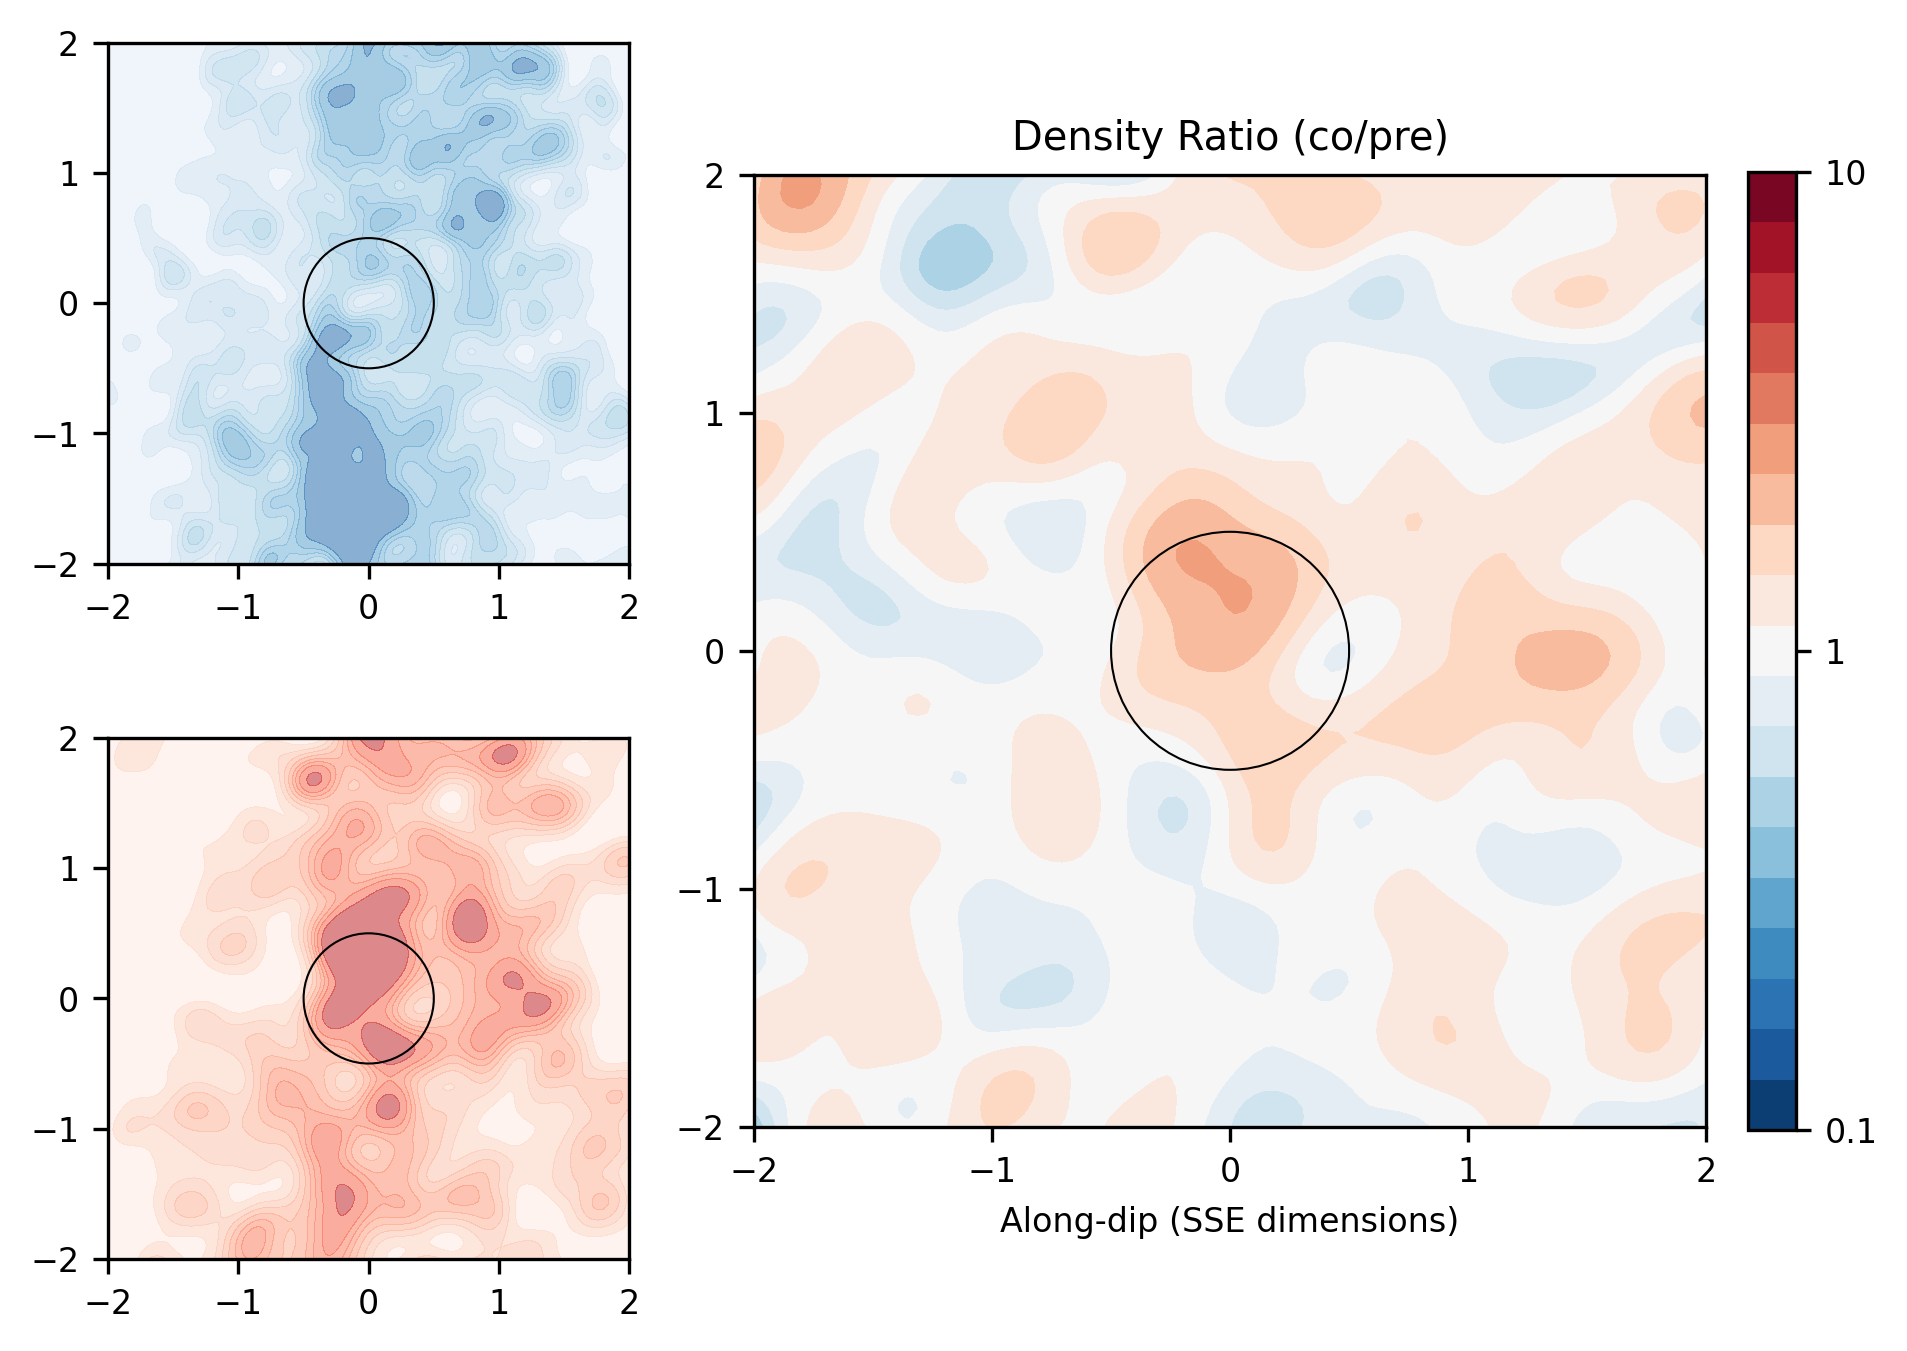

In [ ]:
# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(2, 2, width_ratios=[1, 2])

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
sns.kdeplot(pre_event_stack_combined[:,0], pre_event_stack_combined[:,1], cmap='Blues', label='Pre-event', ax=ax1, **shared_kws, weights=pre_weights)



# Subplot 2 - Bottom plot
ax2 = plt.subplot(gs[1, 0])  # Second row, first column
sns.kdeplot(co_event_stack_combined[:,0], co_event_stack_combined[:,1], cmap='Reds', label='During slow slip', ax=ax2, **shared_kws, weights=co_weights)  


# Subplot 3 - Right plot
ax3 = plt.subplot(gs[:, 1])  # All rows, second column
ch = ax3.contourf(xx, yy, np.log10(density_ratio), levels=np.linspace(-1, 1, 20), cmap='RdBu_r')
# plot colorbar sized to the specific plot
cax3 = plt.colorbar(ch, ax=ax3, fraction=0.046, pad=0.04)

cax3.set_ticks([-1, 0, 1])
cax3.set_ticklabels(['0.1', '1', '10'])
ax3.set(
    xlabel='Along-dip (SSE dimensions)',
)


ax3.set_title('Density Ratio (co/pre)')

for iax in [ax1,ax2,ax3]:
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        xticks=[-2,-1,0,1,2],
        yticks=[-2,-1,0,1,2],
    )
plt.tight_layout()



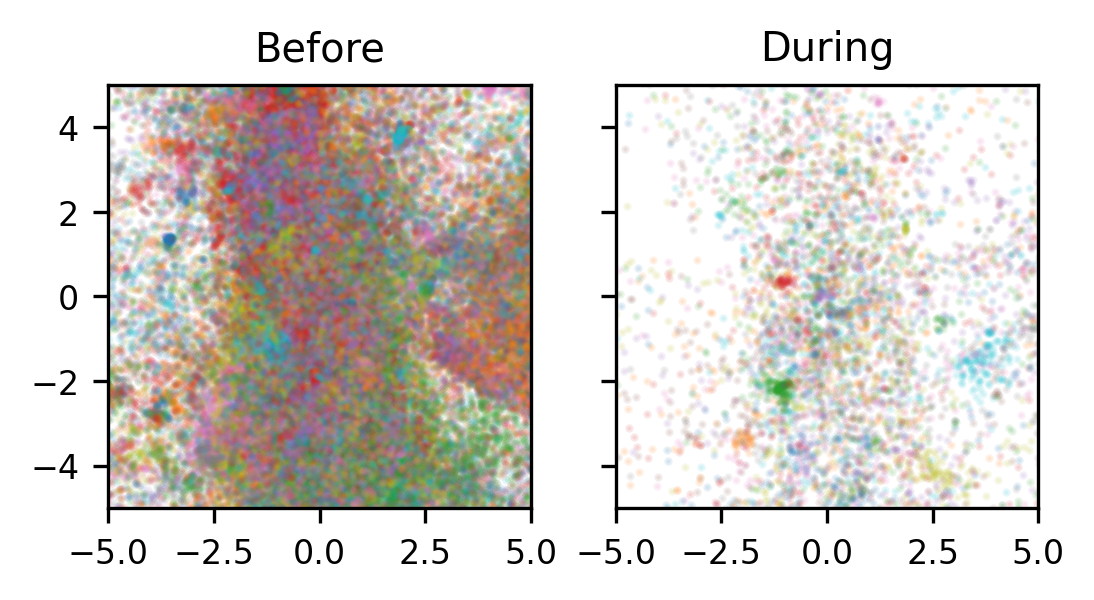

In [ ]:
lim = 5
fig, AX = plt.subplots(1,2,figsize=(4,4),sharex=True,sharey=True)
for ax, stack, title in zip(AX, [pre_event_stack, co_event_stack], ['Before','During']):
    [ax.scatter(events[:,0],events[:,1],s=1,alpha=0.1) for events in stack]
    ax.set(
        xlim=np.array([-lim,lim]),
        ylim=np.array([-lim,lim]),
        aspect='equal',
        title=title,
    )